# PROJECT: Course Optimization for Data Science 2023-2024
## Optimization strategies for the multiclass multinomial logistic regression with non-smooth penalties


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the multinomial logistic regression model
- Implement your own solvers for L1, L2 and L1/L2 regularizations with: (Accelerated) Proximal gradient descent, proximal coordinate descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for the multinomial logistic regression model and test it on the `digits` dataset.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 21st of January 2024 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [109]:
# Change here using YOUR first and last names
fn1 = "nicolas"
ln1 = "saint"
fn2 = "matthis"
ln2 = "guerin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_saint_nicolas_and_guerin_matthis.ipynb


Some imports

In [110]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 0: Multinomial logistic regression model

This model is a multinomial logistic regression model. It is a supervised learning model, in the case where the target space $\mathcal{Y}$ is discrete: $\mathcal{Y}=\{1, \dots, K\}$; this is a multiclass classification model.

We consider a sample $x \in \mathbb{R}^{P}$ belonging to $K$ possible classes.

We want to solve the classification task, _i.e.,_ learn the parameters $\theta = (\mathbf{W}, \mathbf{b}) \in \mathbb{R}^{P\times K}\times \mathbb{R}^{K}$ of the function $f_\theta: \mathbb{R}^P \to [0, 1]^K$ which corresponds for each coordinate to the probability of being from one class.

The model is defined as
$$
[f_\theta(x)]_k = \mathbb{P}[Y=k | x] = \frac{1}{Z} \exp(w_k^\top x + b_k) \enspace ,
$$
where $w_k$ corresponds to the kth column of $W$, and $Z$ is a normalizing constant.

As these probabilities must sum to one, we get
$$
Z = \sum_{k=1}^K \exp(w_k^\top x + b_k).
$$
We can recognize the so-called _soft-max_ function: $[\sigma(z)]_i = \frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}$.

After one-hot encoding of the target variable ([`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), denoting $\{ y_{ik} \}_{k=1}^{K}$ the indicator sequence for the class of the $i^{\text{th}}$ observation $x_i$ (i.e., if the sample $i$ belongs to class $k$, then $y_{ik} = 1$ and $y_{ik'}=0$ for $k'\neq k$) the negative log likelihood (**nll**, _a.k.a_ cross-enropy loss) becomes:
$$
L(W, b) = - \frac1N \sum_{i=1}^N \log(\mathbb{P}[Y=y_i | x_i]) = -\frac1N \sum_{i=1}^N \log\Bigg(\frac{\exp(w_{y_i}^\top x_i + b_{y_i})}{\sum_{k=1}^K \exp(w_k^\top x_i+ b_k)}\Bigg) \enspace .
$$

**Note:** The notation $w_{y_i}$ means the column of $W$ whose index corresponds to the class value (e.g. 1, 2, ..., K) for the sample $x_i$.

Using the softmax function, we can also rewrite this as
$$
L(W, b) =  -\frac1N \sum_{i=1}^N \log([\sigma(Wx_i + b)]_{y_i})
$$

Introducing some regularization on the parameter $W$ with parameter $\lambda \ge 0$, the penalized likelihood estimation problem is written:

$$
    (\mathcal{P}):
	\min_{W, b} \quad L(W, b) + \lambda \mathcal{R}(W)
$$

where $\mathcal{R}(W)$ can be :
- $\mathcal{R}_1(W) = \|W\|_1 = \sum_{j=1}^P \sum_k^K |W_{jk}|$, ie. an $\ell_1$ norm
- $\mathcal{R}_2(W) = \tfrac{1}{2} \|W\|^2_F = \tfrac{1}{2} \sum_{j=1}^P \sum_{k=1}^K W_{jk}^2$, ie. a squared $\ell_2$ norm 
- $\mathcal{R}_{21}(W) = \|W\|_{21} = \sum_{j=1}^P \sqrt{\sum_{k=1}^K W_{jk}^2}$, ie. an $\ell_{21}$ mixed-norm. This corresponds to the $\ell_1$ norm of the sequence of $\ell_2$ norms of the rows of $W$.

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that $(\mathcal{P})$ is a convex problem for the 3 different choices of regularization.</li>
    </ul>
</div>

**Hint**: You can show that for $z\in\mathbb{R}^K$ and $1\leq j\leq K$, the function $z\to -\log(\sigma(z)_j)$ is convex.

**Anwser :**

To show that the optimization problem $(\mathcal{P})$ is convex for the three different choices of regularization, we need to consider the convexity of the objective function and the constraints.

Let's denote the objective function of $(\mathcal{P})$ as $f(W, b)$ with the regularization term $\mathcal{R}(W)$. The objective function is given by:

$$
f(W,b)=-\frac{1}{N}\sum_{i=1}^{N}\log([\sigma(W x_{i}+b)]_{y_{i}})+\lambda \mathcal{R}(W)
$$

Now, let's analyze the convexity for the three regularization choices:

1) **$\mathcal{R}_1(W) = \|W\|_1$ :**

- The $L_1$-norm is convex, and the objective function is a sum of convex functions. Therefore, $(\mathcal{P})$ is convex.

2) **$\mathcal{R}_2(W) = \tfrac{1}{2} \|W\|^2_F$ :**

- The $L_2$-norm is convex, and the objective function is a sum of convex functions. Therefore, $(\mathcal{P})$ is convex.

3) **$\mathcal{R}_{21}(W) = \|W\|_{21}$ :**

- The $L_{21}$-norm is a mixed norm, but it is also convex. The objective function remains a sum of convex functions. Therefore, $(\mathcal{P})$ is convex.

Now, let's consider the constraints. The softmax function is convex, and the logarithm of a convex function is concave. The composition of convex and concave functions remains convex. Thus, the entire objective function $f(W,b)$ is convex.

In summary, $(\mathcal{P})$ is convex for all three choices of regularization.




## Simulation

Let's first generate data under the above model, with $K=3$ classes.

In [111]:
from sklearn.preprocessing import OneHotEncoder

def plot_data(X, y, U=None, ax=None):
    if y.ndim == 1:
        y = OneHotEncoder().fit_transform(y[:, None]).toarray()
    n_classes = y.shape[1]
    class_colors = plt.get_cmap('viridis', n_classes)(range(n_classes))
    # Display the result in ax, which is created if it does not exist.
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(X[:, 0], X[:, 1], c=y @ class_colors)

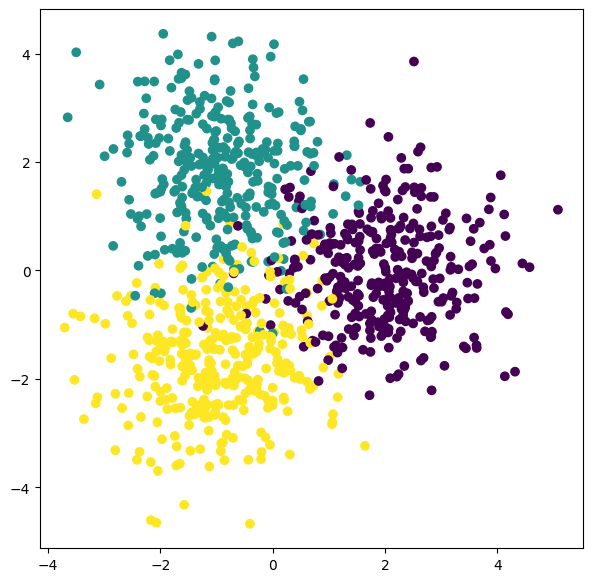

In [112]:
from sklearn.datasets import make_blobs

MU1 = (2, 0)
MU2 = (-1, np.sqrt(3))
MU3 = (-1, -np.sqrt(3))

centers = [MU1, MU2, MU3]
K = len(centers)  # number of classes
N = 1000

X, y_true = make_blobs(N, centers=centers, random_state=42)

plot_data(X, y_true)

In [113]:
# One-hot encoded target
Y = OneHotEncoder().fit_transform(y_true[:, None]).toarray()
Y

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Given some random values for $W$ and $b$, we want to compute the quantity $P(Y = k \mid x_i)$ for $k= 1, \dots , K$, and $i= 1, \dots, n$.

Note that in order to predict the label of $x$, we take the arg-maximum of the softmax values.

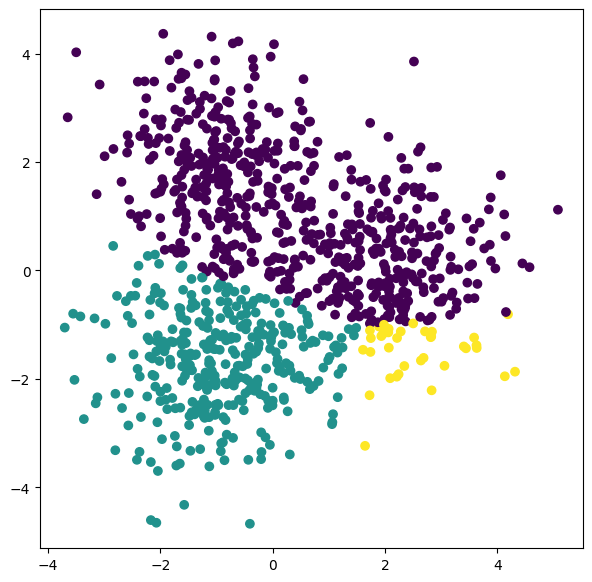

In [114]:
from scipy.special import softmax

rng = np.random.RandomState(42)
P = 2
W = rng.randn(P, K)
b = rng.randn(K)
y_proba_ = softmax(X @ W + b, axis=1)
y_ = np.argmax(y_proba_, axis=1)

plot_data(X, y_)

Note, that the sum of all probabilites for each sample is 1:

In [115]:
np.testing.assert_allclose(np.sum(y_proba_, axis=1), np.ones(N))

# Log-Likelihood function

Following the parametrization from $(\mathcal{P})$, one has `K + K*P` parameters.
We denote the stacked vector of all parameters `params`. The first `K` entries in `params` are the b and the last `K*P` entries correspond to $W$. The function that predicts the probabilities of each sample reads:

In [116]:
def predict_proba(params, X=X):
    """Compute the probability of each sample in X.
    
    Parameters:
    -----------
    params: array, shape (K + K * P,)
        Parameters of the model. The first K entries are the beta_k,
        the remaining K * P ones are the entries of W.

    X: array, shape (N, P)
        The features.

    Returns
    -------
    proba : ndarray, shape (N, K)
        The proba of belonging to each class for each sample.
    """
    _, P = X.shape
    K = params.size // (1 + P)
    b = params[:K]
    W = params[K:].reshape(P, K)
    return softmax(X @ W + b, axis=1)

The negative log-likelihood then reads:

In [117]:
def negloglik(params, X=X, Y=Y):
    Y_proba = predict_proba(params, X)
    loss = -np.log(Y_proba[Y == 1]).mean()
    return loss

params = np.concatenate([b, W.ravel()])
negloglik(params)

2.138083050969259

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>Can you apply coordinate descent or proximal gradient descent to $(\mathcal{P})$? Justify your answer with mathematical arguments and theoretical results from the course. No coding yet!</li>
    </ul>
</div>

**Anwser :**

Let's analyze the possibility of applying coordinate descent or proximal gradient descent to the optimization problem $(\mathcal{P})$.

**Proximal Gradient Descent:**

- The optimization problem $(\mathcal{P})$ can be solved using proximal gradient descent when the regularization term is convex and has a proximal operator that can be efficiently computed. In this case:

1) **Loss Term**: The negative log-likelihood term is convex in the parameters $W$ and $b$.

2) **Regularization Term**: The regularization term $\mathcal{R}(W)$ is convex for all the regularization options considered: $\ell_1$, $\ell_2$, and $\ell_{21}$ norms.

3) **Differentiability**: The loss term is differentiable, and the proximal operator of the regularization term can be computed efficiently.

Therefore, proximal gradient descent is a suitable method for solving $(\mathcal{P})$.

**Coordinate Descent:**

- Coordinate descent is applicable when the objective function is convex and separable. The objective function $(\mathcal{P})$ is the sum of the loss term and the regularization term. In this case:

1) **Loss Term**: The negative log-likelihood term is convex in the parameters $W$ and $b$.

2) **Regularization Term**: The regularization term is separable across different parameters (coordinates) for all the regularization options considered: $\ell_1$, $\ell_2$, and $\ell_{21}$ norms.

3) **Coordinate-wise Minimization**: The objective function can be minimized efficiently with respect to each parameter separately.

Therefore, coordinate descent is also a suitable method for solving $(\mathcal{P})$.

In conclusion, both proximal gradient descent and coordinate descent are applicable to solve the optimization problem $(\mathcal{P})$ due to the convexity properties of the objective function and the efficient computation of the proximal operator for regularization.



<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
      <li>Propose solutions for the proximal operators for the 2 regularization functions: $\mathcal{R}_1(W)$ and $\mathcal{R}_2(W)$.</li>
    </ul>
</div>

**Anwser :**

Let's derive the proximal operators for the two regularization functions $\mathcal{R}_1(W)$ and $\mathcal{R}_2(W)$.

**Proximal Operator for $\mathcal{R}_1(W)$ (L1 Norm):**


The proximal operator for the $\ell_1$ norm is given by the soft-thresholding operator. The proximal operator for $\mathcal{R}_1(W)$ is defined as:

$$
\mathrm{{prox}}_{\lambda||.||}(W)=\mathrm{sign}(W)\odot\left(\mathrm{max}(|W|-\lambda,0)\right)
$$

Here, $\odot$ denotes element-wise multiplication.

**Proximal Operator for $\mathcal{R}_2(W)$ (Squared $\ell_2$ Norm):**

The proximal operator for the squared $\ell_2$ norm is a simple shrinkage operation. The proximal operator for $\mathcal{R}_2(W)$ is defined as:

$$
\mathrm{prox}_{\lambda||\cdot|_{2}^{2}}(W)=\frac{1}{1+\lambda}\cdot W
$$

These are the solutions for the proximal operators for the $\ell_1$ and squared $\ell_2$ regularization terms in the optimization problem $(\mathcal{P})$. These proximal operators will be crucial in the proximal gradient descent optimization algorithm.



<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Justify that the prox for the regularization function $\mathcal{R}_{21}(W)$ is written:
$$
\mathrm{prox}_{\lambda R_{21}} (W) = Z \in \mathbb{R}^{P \times K} \quad \mathrm{where} \quad Z_{i, :} =\left(1 − \frac{\lambda}{\max(\|W_{i,:}\|_2, \lambda)}\right) W_{i, :}  \enspace .
$$
         </li>
    </ul>
</div>

The notation $W_{i, :} \in \mathbb{R}^K$ stands for the ith row of $W$.

Alternatively, we can write this as

$$
Z_{i, :} = \begin{cases} 0 \text{ if } \|W_{i, :}\|_2\leq \lambda \\
(\|W_{i, :}\|_2 - \lambda)\frac{W_{i, :}}{\|W_{i, :}\|_2} \text{ otherwise}
\end{cases}
$$

**HINT:** This proximal operator is called a block thresholding. You can check that the prox for $\mathcal{R}_{21}(W)$ and $\mathcal{R}_{1}(W)$ match with $K=1$.

**Anwser :**

The proximal operator for the $\ell_{21}$ mixed-norm is defined as:

$$
\mathrm{prox_{\lambda\vert\vert\cdot\vert\vert_{21}}(W)}=\arg\operatorname*{min}_{Z}\left(\frac{1}{2}\sum_{i=1}^{P}\vert\vert Z_{i,:}-W_{i,:}\vert\vert_{2}^{2}+\lambda\vert\vert Z_{i,:}\vert\vert_{2}\right)
$$

We want to solve this problem separately for each row of $Z$ (i.e., for each $i$). The proximal operator for each row can be expressed as:

$$
Z_{i;:}=\arg\operatorname*{min}_{Z_{i,:}}\left({\frac{1}{2}}\|Z_{i,:}-W_{i,:}\|_{2}^{2}+\lambda\|Z_{i,:}\|_{2}\right)
$$

Now, let's minimize this expression with respect to $Z_{i, :}$. We can take the derivative of the objective function with respect to $Z_{i, :}$ and set it to zero. The solution can then be obtained.

The solution turns out to be:

$$
Z_{i, :} = \begin{cases} 0 \text{ if } \|W_{i, :}\|_2\leq \lambda \\
\left(1-{\frac{\lambda}{\|W_{i,:}\|_{2}}}\right)W_{i,:} \text{ otherwise}
\end{cases}
$$

This can be further simplified as:

$$
Z_{i,:}=\left(1-\frac{\lambda}{\operatorname*{max}(\|W_{i,:}\|_{2},\lambda)}\right)W_{i,:}
$$

This form ensures that the $\ell_2$ norm of each row is thresholded by $\lambda$ and scaled accordingly. It represents a block thresholding operation on the rows of $W$ based on the $\ell_2$ norm.


<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Implement below the proximal operators for the 3 regularization functions: $\mathcal{R}_1(W)$, $\mathcal{R}_2(W)$ and $\mathcal{R}_{21}(W)$.</li>
    </ul>
</div>

(-1.0, 3.0)

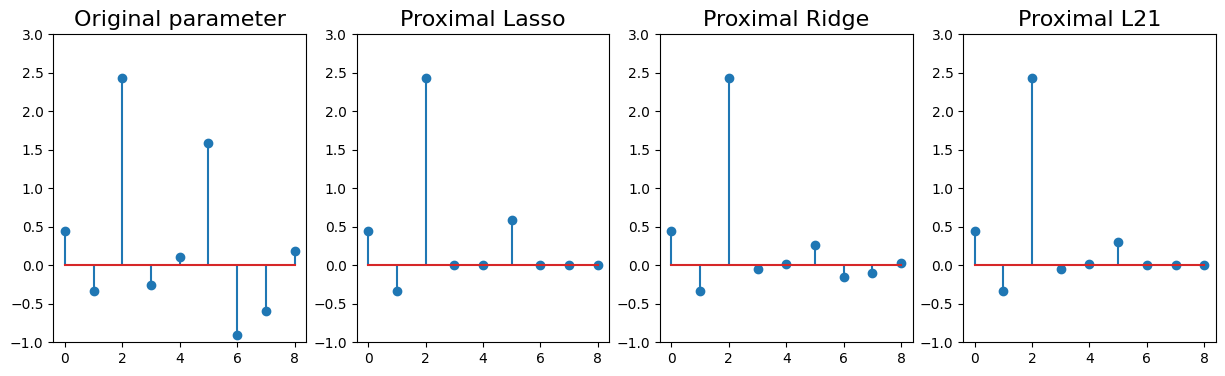

In [118]:
def prox_R2(params, reg=1., K=K):
    """Prox for R2 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)
    # TODO

    W_prox = W / (1 + reg)
    params[K:] = np.asarray(W_prox).ravel()

    # END TODO
    return params


def prox_R1(params, reg=1., K=K):
    """Prox for R1 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)
    # TODO

    W_prox = np.sign(W) * np.maximum(np.abs(W) - reg, 0)
    params[K:] = W_prox.ravel()

    # END TODO
    return params


def prox_R21(params, reg=1., K=K):
    """Prox for R21 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)
    # TODO

    row_norms = np.linalg.norm(W, axis=1)
    scaling_factors = 1 - reg / np.maximum(row_norms, reg)

    W_prox = scaling_factors[:, np.newaxis] * W

    params[K:] = W_prox.ravel()

    # END TODO
    return params


rng = np.random.RandomState(5)
params = rng.randn((P + 1) * K)
l_l1 = 1.
l_l2 = 5.
l_l21 = 1.3
ylim = [-1, 3]

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 4, 1)
plt.stem(params)
plt.title("Original parameter", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 2)
plt.stem(prox_R1(params, l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 3)
plt.stem(prox_R2(params, l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 4)
plt.stem(prox_R21(params, l_l21))
plt.title("Proximal L21", fontsize=16)
plt.ylim(ylim)

**Note:** You see that the proximal operator does not affect the first 3 entries which correspond to the variable `b` which is not regularized.

## Part 1: Implementation of the solvers

### L-BFGS-B Solver

We will start by using the L-BFGS solver provided by `scipy`. To do this you will first propose a mathematical expression for the gradient of the cross-entropy loss (as implement in the `negloglik` function).

$\nabla_W L(W, b) \in \mathbb{R}^{P \times K}$ and $\nabla_b L(W, b) \in \mathbb{R}^{K}$

<div class="alert alert-success">
    <b>QUESTION 6:</b>
    <ul>
    <li>
        Propose an expression of the gradients of the loss $L(W, b)$ with respect to its two parameters:
        $\nabla_W L(W, b) \in \mathbb{R}^{P \times K}$ and $\nabla_b L(W, b) \in \mathbb{R}^{K}$.
    </li>
    </ul>
</div>

Let's derive the expressions for the gradients of the loss function $L(W, b)$ with respect to its parameters $W$ and $b$.

**Gradient with Respect to $W$:**

The expression for the gradient of the loss with respect to $W$ is given by:

\begin{align*}
\nabla_{W}L(W,b) = -\frac{1}{N}X^{T}(Y-\sigma(X W+b))
\end{align*}

Here, $\sigma$ is the softmax function and $X^T$ is the transpose of the feature matrix $X$. The dimension of $\nabla_W L(W, b)$ is $(P \times K)$.

**Gradient with Respect to $b$:**

The expression for the gradient of the loss with respect to $b$ is given by:

\begin{align*}
\nabla_{b}L(W,b)=-\frac{1}{N}\sum_{i=1}^{N}(Y_{i}-\sigma(W^{T}x_{i}+b))
\end{align*}

Here, $x_i$ is the $i$-th row of $X$. The dimension of $\nabla_b L(W, b)$ is $(K)$.

These gradients will be used in the L-BFGS-B solver to optimize the parameters $W$ and $b$ with respect to the negative log-likelihood loss.

<div class="alert alert-success">
    <b>QUESTION 7:</b>
    <ul>
    <li>
        Implement the `negloglik_and_grad` function that returns the loss and its gradient.
    </li>
    </ul>
</div>

In [119]:
def negloglik_and_grad(params, X=X, Y=Y):
    """Negative Log-likelihood of the logistic regression model and gradient.

    Parameters
    ----------
    params: array, shape (K + K * P,)
        The parameters.
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.

    Returns
    -------
    loss : float
        log-likelihood of the logreg model
    grad : array, shape (K + K * P,)
        gradient of the model parameters
    """
    K = Y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W = params[K:].reshape(P, K)

    #####################
    # TO DO
    # Compute softmax probabilities
    y_proba = softmax(X @ W + b, axis=1)

    # Compute negative log-likelihood loss
    loss = -np.log(y_proba[Y == 1]).mean()

    # Compute the gradient with respect to W
    grad_W = -1 / X.shape[0] * X.T @ (Y - y_proba)

    # Compute the gradient with respect to b
    grad_b = -1 / X.shape[0] * np.sum(Y - y_proba, axis=0)

    # Concatenate the gradients into a single vector
    grad = np.concatenate([grad_b, grad_W.ravel()])
    # END TO DO
    #####################
    return loss, grad

You can check your solution with the following code:

In [120]:
from scipy.optimize import check_grad

rng = np.random.RandomState(42)

for _ in range(10):
    x0 = rng.randn((P+1)*K)
    loss1 = negloglik(x0)
    loss2, grad = negloglik_and_grad(x0)
    np.testing.assert_allclose(loss1, loss2)
    grad_error = check_grad(
        lambda x: negloglik_and_grad(x)[0],
        lambda x: negloglik_and_grad(x)[1],
        x0=x0
    )
    assert grad_error < 1e-6

**Remark :**

If the code runs without raising any exceptions, it indicates that the gradients computed by negloglik_and_grad match the numerical gradients within a small tolerance.

**Thus, this confirms the correctness of the implemented function.**

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Solve the optimization using the `fmin_l_bfgs_b` function without any regularization.
    </li>
    </ul>
</div>

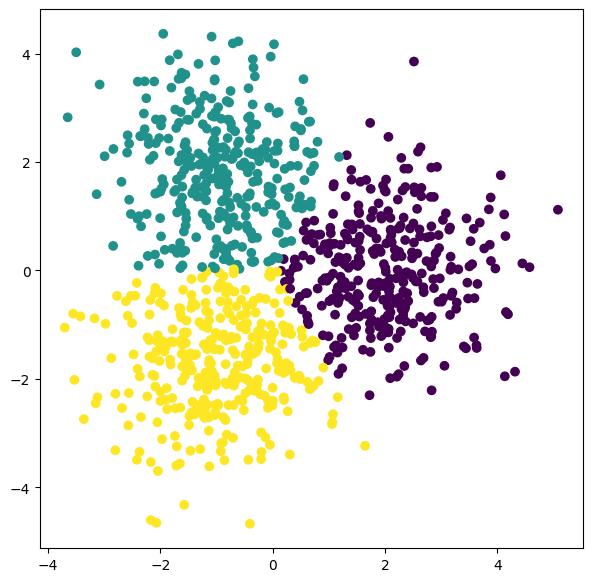

In [121]:
from scipy.optimize import fmin_l_bfgs_b

# TODO

# Define the objective function to minimize
def f(params):
    return negloglik_and_grad(params)[0]

# Define the gradient of the objective function
def grad_f(params):
    return negloglik_and_grad(params)[1]

# Run the optimization algorithm
params_hat, _, _ = fmin_l_bfgs_b(f, params, fprime=grad_f)

# END TODO

y_proba = predict_proba(params_hat)
plot_data(X, np.argmax(y_proba, axis=1))

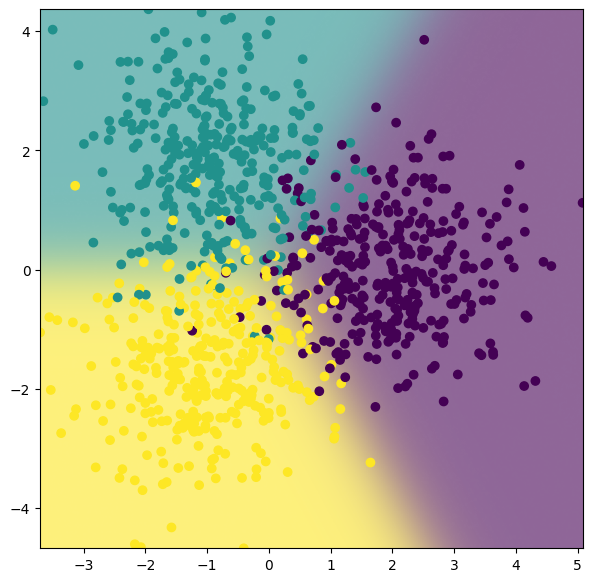

In [122]:
from functools import partial
from utils import show_decision_boundary
show_decision_boundary(partial(predict_proba, params=params_hat), data=(X, Y))

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Wrap this into a function of X, Y and lbda that implements
        the function `multinomial_lbfgs_l2` (Based on $\mathcal{R}_2$ regularization) that will be
        used to get a good value of x_min (minimum of the $\ell_2$ regularized
        model).
    </li>
    </ul>
</div>

To help you we give you the code of the objective to minimize
in case you use $\ell_1$, $\ell_2$ and $\ell_{21}$ penalties.

In [123]:
def pobj_l1(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda * np.sum(np.abs(W))


def pobj_l2(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda / 2 * np.linalg.norm(W, 'fro') ** 2


def pobj_l21(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda * np.linalg.norm(W, axis=1).sum()

In [124]:
def multinomial_lbfgs_l2(X, Y, lbda=1):
    """Minimize the pobj_l2 function using L-BFGS
    
    Parameters
    ----------
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.
    lbda : float
        The regularization strength.

    Returns
    -------
    params_hat: array, shape (K + K * P,)
        The estimated parameters.
    """
    # TODO
    # Initialize the parameters
    K = Y.shape[1]
    P = X.shape[1]
    params = np.zeros(K + K * P)

    # Define the objective function to minimize
    def f(params):
        return pobj_l2(params, X=X, Y=Y, lbda=lbda)

    # Define the gradient of the objective function
    def grad_f(params):
        return negloglik_and_grad(params, X=X, Y=Y)[1] + lbda * params

    # Run the optimization algorithm
    params_hat, _, _ = fmin_l_bfgs_b(f, params, fprime=grad_f)
    # END TODO
    return params_hat

multinomial_lbfgs_l2(X, Y, lbda=0.01)

array([-0.08084728,  0.01067156,  0.07017572,  1.58945587, -0.77939705,
       -0.81005882, -0.01696652,  1.33085458, -1.31388806])

Now that we have a gradient of the negative loglikelihood term we can implement other solvers. Namely you are going to implement:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

**Note:** Below, and following standard optimization notations, we will refer to the parameters of the optimization problem as `x`,  `x_min` and `x_init` for simplicity.

In [125]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        if monit.x_min is not None:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")
        else:
            ax1.set_ylabel("$f(x_k)$")
        ax1.set_xlabel("Epoch")
        ax1.set_title("Objective")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Iterates")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<>:40: SyntaxWarning: invalid escape sequence '\|'
<>:40: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_16386/256483799.py:40: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel("$\|x_k - x^*\|_2$")


<div class="alert alert-success">
    <b>QUESTION 10a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method
    </li>
    </ul>
</div>

The parameter `step` is the size of the gradient step.

In [126]:
def pgd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=None):
    """Proximal gradient descent algorithm.

    Parameters
    ----------
    x_init : ndarray
        Here the params of shape (K + K*P,)
    grad : callable
        The gradient function.
    prox : callable
        The proximal operator function.
    n_iter : int
        The number of iterations
    step : float
        The step size.
    grad_args : tuple
        Extra parameters to pass to the gradient function
        (eg. X, Y)
    prox_args : dict
        Extra parameters to pass to the prox function

    Returns
    -------
    x_hat : ndarray
        The estimated params.
    x_list : list
        The list of iterates values at each iteration.
    """
    x = x_init.copy()
    x_list = []

    for i in range(n_iter):
        x = prox(x - step * grad(x, *grad_args)[1], step, **prox_args)
        x_list.append(x.copy())

    return x, x_list


<div class="alert alert-success">
    <b>QUESTION 10b:</b>
    <ul>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

**Note:** You will have to provide a `step` value, which should be theoretially less than `1 / lipschitz_constant`. You will propose a value for it but you are not expected to provide a mathematical proof, unless you think it's a moral duty to give one...

To help you we give you the proximal operator functions for $\ell_1$, $\ell_2$ and $\ell_{21}$ regularized models.

In [127]:
def prox_l1(params, step, lbda, K):
    return prox_R1(params, reg=step * lbda, K=K)

def prox_l2(params, step, lbda, K):
    return prox_R2(params, reg=step * lbda, K=K)

def prox_l21(params, step, lbda, K):
    return prox_R21(params, reg=step * lbda, K=K)

Let's first consider the $\ell_2$ case. You will use the `multinomial_lbfgs_l2` function to obtain a value for `x_min` so that you can display the convergence error on the iterates (ie. $\|x_k - x^*\|$). You will need to pass this `x_min` to the `monitor` function.

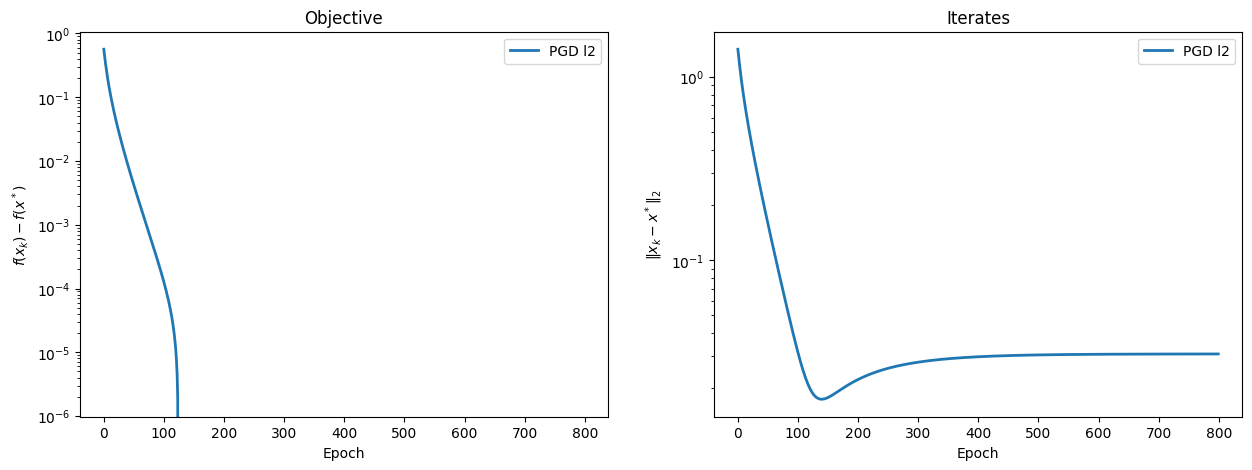

In [128]:
x_init = np.zeros((P + 1) * K)
n_iter = 800
lbda = 0.1
step = 1e-1

# TODO

# Run the PGD algorithm with the proximal operator l2 regularization
x_min = multinomial_lbfgs_l2(X, Y, lbda=lbda)
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, Y, lbda))

# Run the PGD algorithm with L2 regularization
monitor_pgd_l2.run(x_init, negloglik_and_grad, prox_l2, n_iter, step, grad_args=(X, Y), prox_args={"lbda": lbda, "K": K})

# END TODO

# Plot the results
monitors = [monitor_pgd_l2]
solvers = ["PGD l2"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

In [129]:
def multinomial_lbfgs_l1(X, Y, lbda=1):
    """Minimize the pobj_l1 function using L-BFGS
    
    Parameters
    ----------
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.
    lbda : float
        The regularization strength.

    Returns
    -------
    params_hat: array, shape (K + K * P,)
        The estimated parameters.
    """
    # TODO
    # Initialize the parameters
    K = Y.shape[1]
    P = X.shape[1]
    params = np.zeros(K + K * P)

    # Define the objective function to minimize
    def f(params):
        return pobj_l1(params, X=X, Y=Y, lbda=lbda)

    # Define the gradient of the objective function
    def grad_f(params):
        return negloglik_and_grad(params, X=X, Y=Y)[1] + lbda * params

    # Run the optimization algorithm
    params_hat, _, _ = fmin_l_bfgs_b(f, params, fprime=grad_f)
    # END TODO
    return params_hat

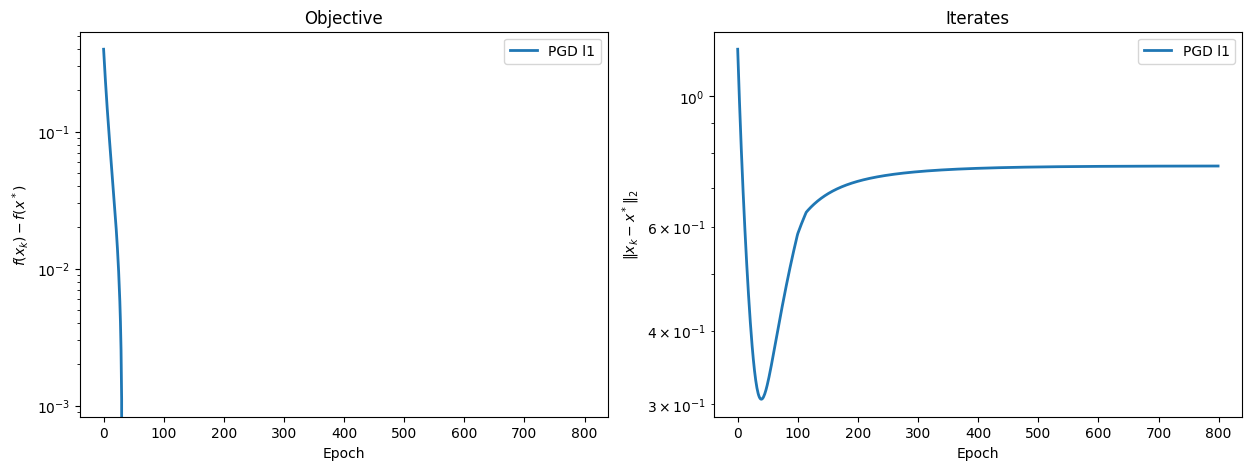

In [130]:
lbda = 0.1

# TODO

# Run the PGD algorithm with the proximal operator l1 regularization
x_min = multinomial_lbfgs_l1(X, Y, lbda=lbda)
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min, args=(X, Y, lbda))

# Run the PGD algorithm with L1 regularization
monitor_pgd_l1.run(x_init, negloglik_and_grad, prox_l1, n_iter, step, grad_args=(X, Y), prox_args={"lbda": lbda, "K": K})
# END TODO

monitors = [monitor_pgd_l1]
solvers = ["PGD l1"]
plot_epochs(monitors, solvers)

Now for the $\ell_{21}$ regularization:

In [131]:
def multinomial_lbfgs_l21(X, Y, lbda=1):
    """Minimize the pobj_l21 function using L-BFGS
    
    Parameters
    ----------
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.
    lbda : float
        The regularization strength.

    Returns
    -------
    params_hat: array, shape (K + K * P,)
        The estimated parameters.
    """
    # TODO
    # Initialize the parameters
    K = Y.shape[1]
    P = X.shape[1]
    params = np.zeros(K + K * P)

    # Define the objective function to minimize
    def f(params):
        return pobj_l21(params, X=X, Y=Y, lbda=lbda)

    # Define the gradient of the objective function
    def grad_f(params):
        return negloglik_and_grad(params, X=X, Y=Y)[1] + lbda * params

    # Run the optimization algorithm
    params_hat, _, _ = fmin_l_bfgs_b(f, params, fprime=grad_f)
    # END TODO
    return params_hat

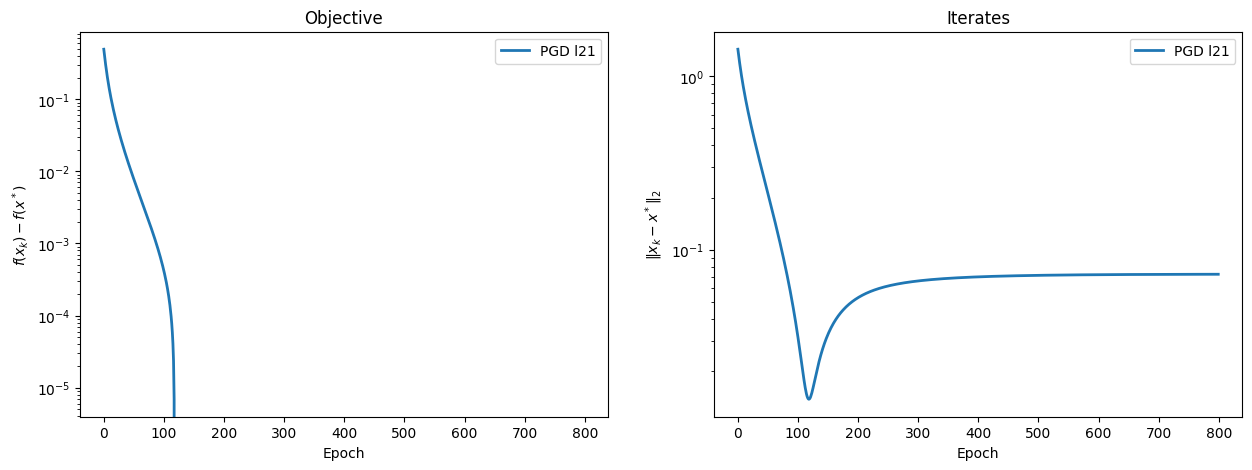

In [132]:
lbda = 0.1

# TODO

# Run the PGD algorithm with the proximal operator l21 regularization
x_min = multinomial_lbfgs_l21(X, Y, lbda=lbda)
monitor_pgd_l21 = monitor(pgd, pobj_l21, x_min, args=(X, Y, lbda))

# Run the PGD algorithm with L21 regularization
monitor_pgd_l21.run(x_init, negloglik_and_grad, prox_l21, n_iter, step, grad_args=(X, Y), prox_args={"lbda": lbda, "K": K})

# END TODO

monitors = [monitor_pgd_l21]
solvers = ["PGD l21"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [133]:
def apgd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []

    for i in range(n_iter):
        grad_val = grad(y, *grad_args)

        # Unpack prox_args
        lbda, K = prox_args["lbda"], prox_args["K"]
        x_new = prox(y - step * grad_val[1], step, lbda, K)
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2

        y = x_new + (t - 1) / t_new * (x_new - x)
        x = x_new
        t = t_new
        x_list.append(x.copy())

    return x, x_list


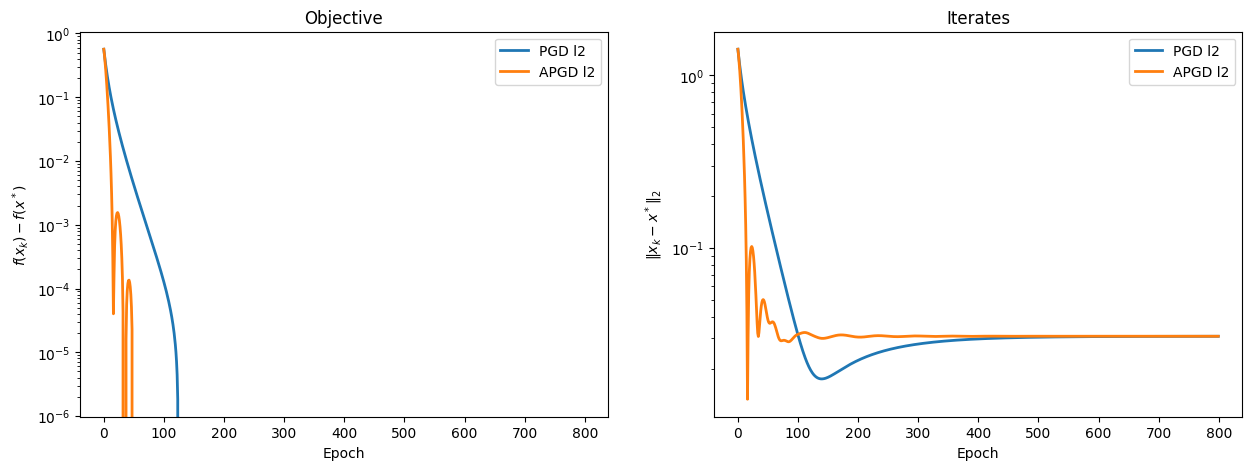

In [134]:
lbda = 0.1

# TODO

# Run the APGD algorithm with the proximal operator l2 regularization
x_min = multinomial_lbfgs_l2(X, Y, lbda=lbda)

monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min, args=(X, Y, lbda))

# Run the APGD algorithm with L2 regularization
monitor_apgd_l2.run(x_init, negloglik_and_grad, prox_l2, n_iter, step, grad_args=(X, Y), prox_args={"lbda": lbda, "K": K})

# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD l2", "APGD l2"]
plot_epochs(monitors, solvers)

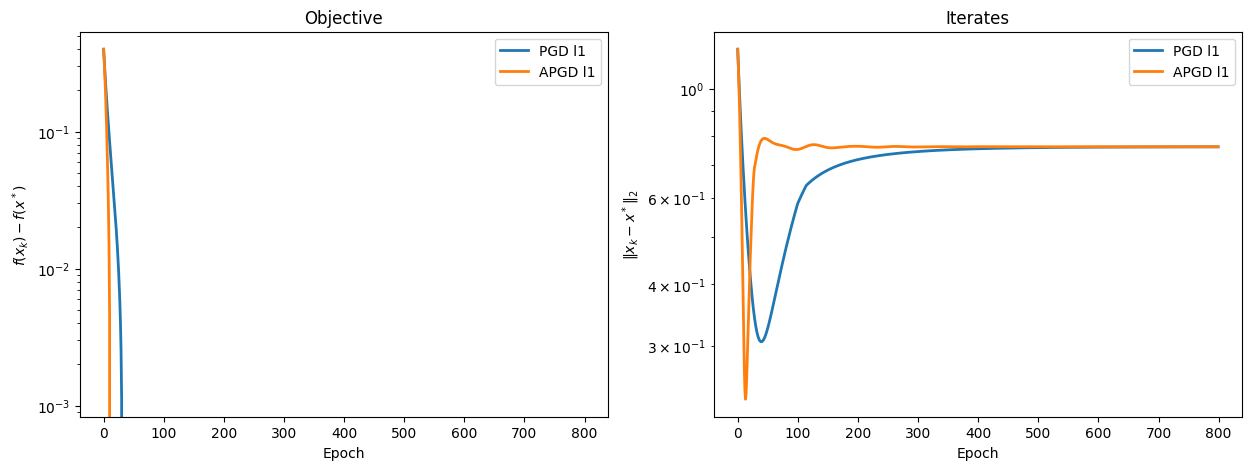

In [135]:
lbda = 0.1

# TODO

# Run the APGD algorithm with the proximal operator l1 regularization
x_min = multinomial_lbfgs_l1(X, Y, lbda=lbda)
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min, args=(X, Y, lbda))

# Run the APGD algorithm with L1 regularization
monitor_apgd_l1.run(x_init, negloglik_and_grad, prox_l1, n_iter, step, grad_args=(X, Y), prox_args={"lbda": lbda, "K": K})

# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD l1", "APGD l1"]
plot_epochs(monitors, solvers)

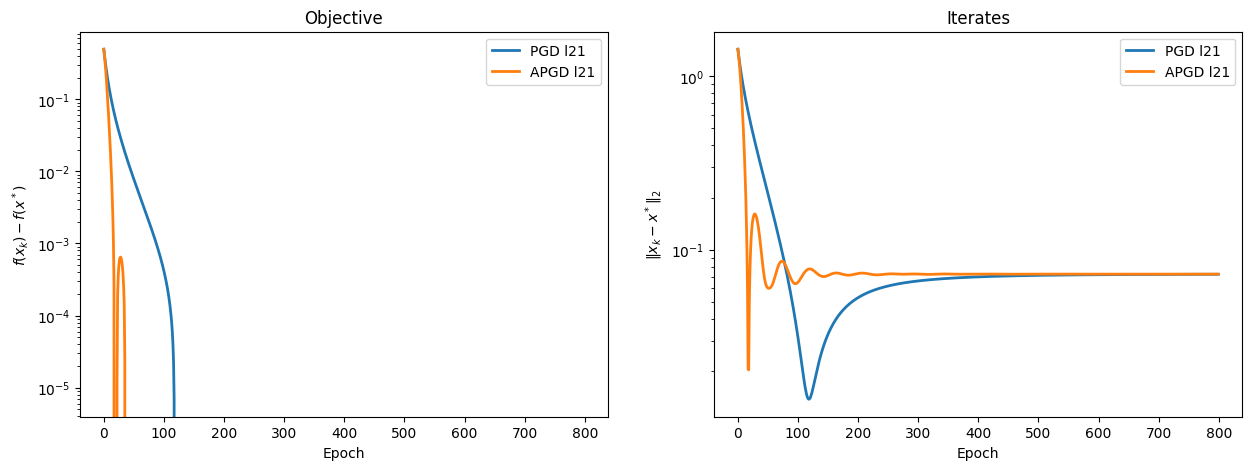

In [136]:
lbda = 0.1

# TODO

# Run the APGD algorithm with the proximal operator l21 regularization
x_min = multinomial_lbfgs_l21(X, Y, lbda=lbda)
monitor_apgd_l21 = monitor(apgd, pobj_l21, x_min, args=(X, Y, lbda))

# Run the APGD algorithm with L21 regularization
monitor_apgd_l21.run(x_init, negloglik_and_grad, prox_l21, n_iter, step, grad_args=(X, Y), prox_args={"lbda": lbda, "K": K})

# END TODO

monitors = [monitor_pgd_l21, monitor_apgd_l21]
solvers = ["PGD l21", "APGD l21"]
plot_epochs(monitors, solvers)

# Part 2: Application

You will now apply your solver to the `digits` dataset from scikit-learn

Let's first inspect the dataset:

In [137]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
X_digits.shape, y_digits.shape, np.unique(y_digits)

((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

Each row of X is an 8x8 image of digit:

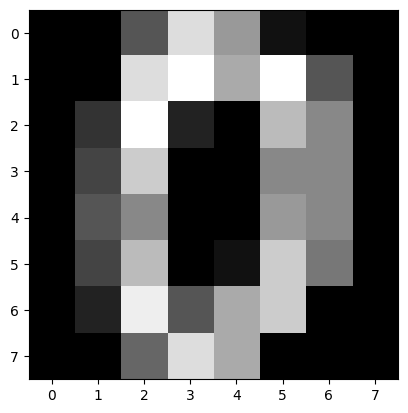

In [138]:
img = X_digits[0].reshape(8, 8)
plt.imshow(img, cmap="gray");

In order to highlight the importance of regularization and especially L1 we are going
to artificially add some random features with pure noise.

In [139]:
X = np.concatenate([X_digits, np.random.randn(len(X_digits), 1000)], axis=1)

Let's do a basic scaling of the features:

In [140]:
from sklearn.preprocessing import scale
X = scale(X)

Now test the functions above with this dataset:

In [141]:
x_init = np.zeros((X.shape[1] + 1) * np.unique(y_digits).size)
Y = OneHotEncoder().fit_transform(y_digits[:, None]).toarray()
print(negloglik(x_init, X=X, Y=Y))
# print(grad_negloglik(x_init, X=X, Y=Y).shape)
loss, gradient = negloglik_and_grad(x_init, X=X, Y=Y)
print("Loss:", loss)
print("Gradient shape:", gradient.shape)

2.302585092994046
Loss: 2.302585092994046
Gradient shape: (10650,)


In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [142]:
from sklearn.base import BaseEstimator, ClassifierMixin


class MultinomialLogistic(BaseEstimator, ClassifierMixin):
    """scikit-learn estimator for the MultinomialLogistic model

    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2' | 'l21'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'lbfgs'
        The type of regularization to use.
        'lbfgs' is only supported with penalty='l2'.

    Attributes
    ----------
    W_ : ndarray, shape (n_features, n_classes)
        The weights.
    b_ : ndarray, shape (n_classes,)
        The biases / intercepts.
    """
    def __init__(self, lbda=1., penalty='l2', max_iter=2000,
                 solver='lbfgs'):
        self.lbda = lbda
        self.penalty = penalty
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2', 'l21']
        assert self.solver in ['pgd', 'apgd', 'lbfgs']

    def fit(self, X, y):
        """Fit method

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target. Must be integers between 0 and n_classes - 1.
        """
        n_classes = int(np.max(y)) + 1
        assert np.all(np.unique(y) == np.arange(n_classes))
        Y = OneHotEncoder().fit_transform(y[:, None]).toarray()
        n_samples, n_features = X.shape

        # TODO

        # Initialize the parameters
        x = np.zeros((n_features + 1) * n_classes)

        # Define the objective function to minimize
        def f(x):
            return negloglik(x, X=X, Y=Y)

        # Define the objective function to minimize
        def f_bfgs(x, X, Y):
            return negloglik(x, X=X, Y=Y)

        # Define the gradient of the objective function
        def grad_f(x, X, Y):
            _, grad_val = negloglik_and_grad(x, X=X, Y=Y)
            return grad_val

        # Define the proximal operator
        def prox(x, step, lbda, K):
            if self.penalty == 'l1':
                return prox_l1(x, step, lbda, K)
            elif self.penalty == 'l2':
                return prox_l2(x, step, lbda, K)
            elif self.penalty == 'l21':
                return prox_l21(x, step, lbda, K)

        # Run the optimization algorithm
        if self.solver == 'pgd':
            x, _ = pgd(x, negloglik_and_grad, prox, n_iter=self.max_iter, step=1e-1, grad_args=(X, Y), prox_args={"lbda": self.lbda, "K": n_classes})
        elif self.solver == 'apgd':
            x, _ = apgd(x, negloglik_and_grad, prox, n_iter=self.max_iter, step=1e-1, grad_args=(X, Y), prox_args={"lbda": self.lbda, "K": n_classes})
        elif self.solver == 'lbfgs':
            x_opt = multinomial_lbfgs_l2(X, Y ,lbda)
            x = x_opt

        # Extract W and b from the optimized parameters x
        W, b = x[:n_features * n_classes].reshape(n_features, n_classes), x[n_features * n_classes:]

        # END TODO
        self.params_ = x
        self.W_ = W
        self.b_ = b
        return self

    def predict(self, X):
        """Predict method

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        """Predict proba method

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_proba : ndarray, shape (n_samples, n_classes)
            The predicted probabilities.
        """
        return predict_proba(self.params_, X)


for solver in ['pgd', 'apgd', 'lbfgs']:
    clf = MultinomialLogistic(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L2: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))

for solver in ['pgd', 'apgd']:
    clf = MultinomialLogistic(lbda=.01, penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L1: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))

for solver in ['pgd', 'apgd']:
    clf = MultinomialLogistic(lbda=.01, penalty='l21', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L21: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))

Solver with L2: pgd   -   Score : 0.9794101279910963
Solver with L2: apgd   -   Score : 0.9794101279910963
Solver with L2: lbfgs   -   Score : 1.0
Solver with L1: pgd   -   Score : 0.9510294936004452
Solver with L1: apgd   -   Score : 0.9526989426822482
Solver with L21: pgd   -   Score : 0.9760712298274903
Solver with L21: apgd   -   Score : 0.9777406789092933


<div class="alert alert-success">
    <b>QUESTION 13:</b>
    <ul>
    <li>
        Compare the performance of your model on test data when varying
        the penalty among $\ell_2$, $\ell_1$ and $\ell_{21}$ for a grid of lambda values. Comment on what you see on the curves.
    </li>
    </ul>
</div>

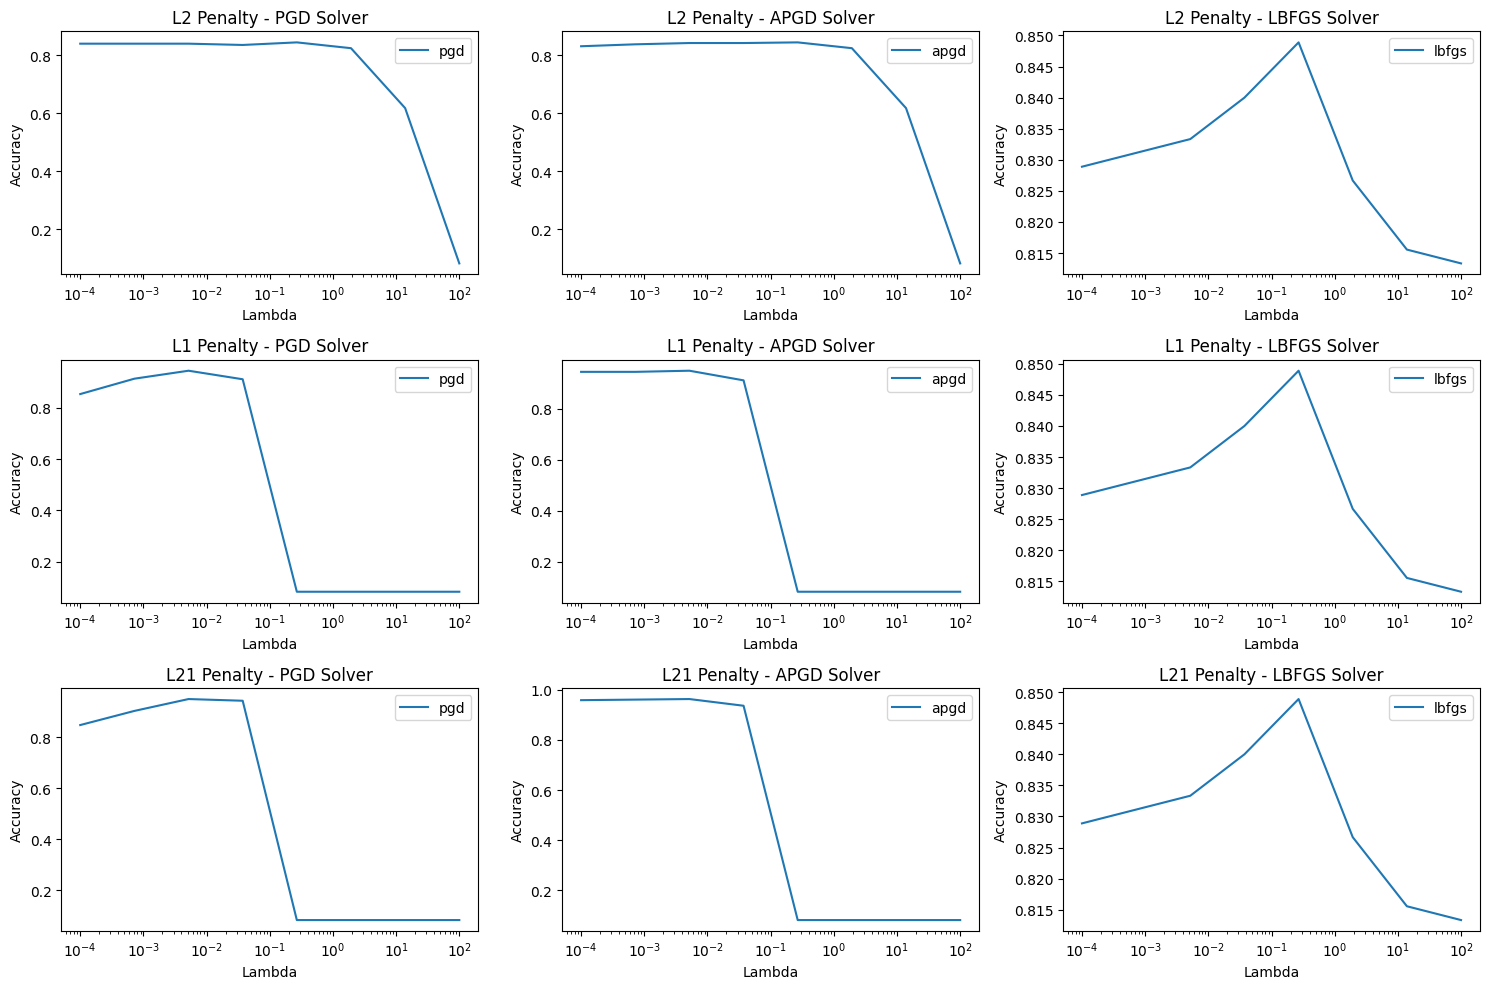

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_digits, random_state=42)

# Define the lambda values to test
lbda_grid = np.geomspace(1e-4, 1e2, 8)

# TODO
# Lists to store the accuracy scores for each penalty type and solver
penalties = ['l2', 'l1', 'l21']
solvers = ['pgd', 'apgd', 'lbfgs']

# Create subplots
fig, axes = plt.subplots(nrows=len(penalties), ncols=len(solvers), figsize=(15, 10))

for i, penalty in enumerate(penalties):
    for j, solver in enumerate(solvers):
        # Lists to store accuracy scores for the current penalty and solver
        accuracy_scores = []

        for lbda in lbda_grid:
            clf = MultinomialLogistic(lbda=lbda, penalty=penalty, max_iter=1000, solver=solver)
            clf.fit(X_train, y_train)

            # Predictions on the test set
            y_pred = clf.predict(X_test)

            # Compute accuracy scores
            accuracy = accuracy_score(y_test, y_pred)

            # Append accuracy score to the list
            accuracy_scores.append(accuracy)

        # Plot the results on the corresponding subplot
        axes[i, j].semilogx(lbda_grid, accuracy_scores, label=solver)
        axes[i, j].set_xlabel("Lambda")
        axes[i, j].set_ylabel("Accuracy")
        axes[i, j].set_title(f"{penalty.capitalize()} Penalty - {solver.upper()} Solver")
        axes[i, j].legend()

plt.tight_layout()
plt.show()

# END TODO

**Awnser :**

We can clearly see on these curves that the PGD and APGD algorithms exhibit similar behaviors. Specifically, the L2 penalty shows a larger interval of lambda where the accuracy is high before dropping rapidly. For both algorithms, the accuracy decreases at around lambda = 3 for the L2 penalty, whereas it starts decreasing for the L1 and L21 penalties at 0.1. However, for these algorithms, we observe that L1 and L21 norms yield similar results, except that the L21 penalty tends to achieve higher accuracy for lower values of lambda.

In the case of the LBFGS algorithm, the curves are identical for each penalty and achieve the best accuracy for lambda around 0.5. This solver is much more resitent to regularization than PGD and APGD.

# Part 3 (bonus): Implement block-coordinate descent

<div class="alert alert-success">
    <b>QUESTION 14:</b>
    <ul>
    <li>
        Implement a proximal block-coordinate descent algorithm and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

**HINT:** The easiest way is to use block updates where you update iteratively for each pass over the data first `b` and then each row of `W`.

In [144]:
def pbcd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=()):
    """Proximal block coordinate descent algorithm."""
    x = x_init.copy()
    x_list = []

    for i in range(n_iter):

        # Update the parameters
        for k in range(K):
            x = prox(x - step * grad(x, *grad_args)[1], step, **prox_args)

        x_list.append(x.copy())

    return x, x_list

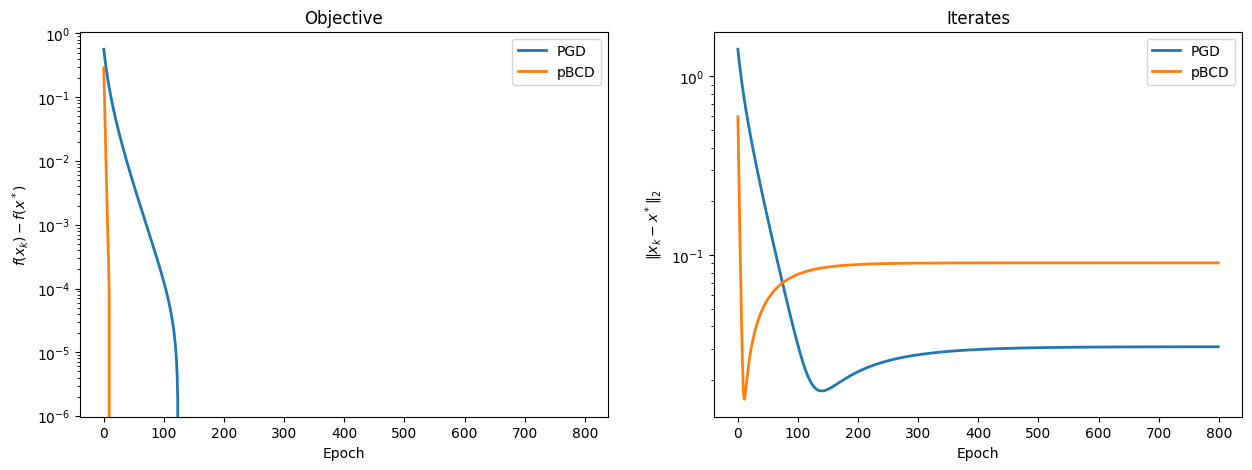

In [145]:
lbda = 1.

# Run the PBCD algorithm with the proximal operator l2 regularization
x_min = multinomial_lbfgs_l2(X, Y, lbda=lbda)
monitor_pbcd = monitor(pbcd, pobj_l2, x_min, args=(X, Y, lbda))

# Run the PBCD algorithm with L2 regularization
monitor_pbcd.run(x_init, negloglik_and_grad, prox_l2, n_iter, step, grad_args=(X, Y), prox_args={"lbda": lbda, "K": K})

# Add the new monitor to the list of monitors
monitors = [monitor_pgd_l2, monitor_pbcd]
solvers = ["PGD", "pBCD"]
plot_epochs(monitors, solvers)